In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc_absolute
%store -r Y_relative_footsteps_acc_absolute
print(X_relative_footsteps_acc_absolute.shape)
print(Y_relative_footsteps_acc_absolute.shape)

(9780, 28)
(9780, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_relative_footsteps_acc_absolute[:, 24] == 1)[0]
X_relative_footsteps_acc_absolute_RR_swing = X_relative_footsteps_acc_absolute[idxs]
Y_relative_footsteps_acc_absolute_RR_swing = Y_relative_footsteps_acc_absolute[idxs]

## Predict FL foot -> x

In [8]:
X_relative_footsteps_acc_absolute_RR_swing[0, :]

array([ 0.        ,  0.        , -0.1       ,  0.03223521, -0.16707049,
        0.01633024, -0.05086472,  0.01613139, -0.08244775,  0.22421836,
        0.2146329 , -0.40479645,  0.23125328, -0.18591964, -0.40580276,
       -0.2571617 ,  0.15356685, -0.40042184, -0.2596469 , -0.13334387,
       -0.40039383,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [9]:
Y_relative_footsteps_acc_absolute_RR_swing[0, :]

array([-3.85098328e-04, -3.36410252e-03,  5.40918657e-03,  1.06705281e-05])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, 3:9], # felt velocities
               X_relative_footsteps_acc_absolute_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RR_swing[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9397722067689837
RMSE:  0.019412583352489736
The lowest error is:  2.3333179005380345e-05
The highest error is:  0.12889053376521079
The avg. error is:  0.012490330629417958


In [11]:
model_rr_relative_swinging_x.coef_

array([[ 0.02955762,  0.1432621 , -0.04151896,  0.16966638, -0.00349037,
        -0.07295244, -0.09448333, -0.02616144, -0.11079691,  0.02199614,
         0.0346485 , -0.11885317,  0.30968237, -0.44383705, -0.5538524 ,
        -0.46948078,  1.41342596, -1.12849994, -1.52378962, -0.29375091]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([0.16684358])

Text(0, 0.5, 'Predictions')

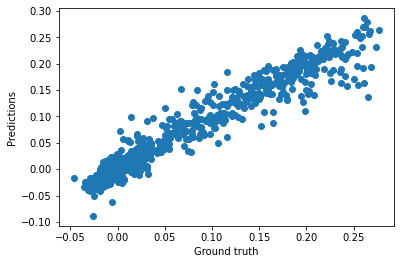

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [17]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_RR_swing[:, 3:9], # felt velocities
               X_relative_footsteps_acc_absolute_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_RR_swing[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8980679572012346
RMSE:  0.015263898701881143
The lowest error is:  9.470507581904597e-07
The highest error is:  0.08025085250046224
The avg. error is:  0.00938874608409814


In [18]:
model_rr_relative_swinging_y.coef_

array([[ 0.03638912,  0.18701459,  0.0954422 , -0.01548988,  0.1574662 ,
        -0.00257799,  0.02134739, -0.10280393, -0.02216174,  0.00889261,
         0.03276828, -0.07616043,  0.20511595,  0.09373271, -0.29935101,
         0.24284354,  0.08618278, -0.59123267, -0.04102567, -0.72838794]])

In [19]:
model_rr_relative_swinging_y.intercept_

array([0.03393695])

Text(0, 0.5, 'Predictions')

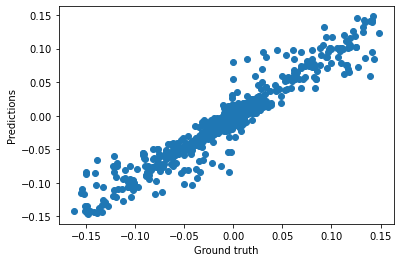

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")